In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.metrics import f1_score, precision_score, recall_score

# ==== Kiểm tra GPU ====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")

# ==== Cài đặt ====
data_dir = r"C:/Users/Admin/Documents/Python Project/Res conn 2025/final_data/not_seg"
img_size = 224
batch_size = 32
num_workers = 4

# ==== Data Augmentation và chuẩn hóa ====
train_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# ==== Load full dataset ====
full_dataset = datasets.ImageFolder(data_dir)
class_names = full_dataset.classes
num_classes = len(class_names)

# ==== Chia dữ liệu train/val/test ====
train_idx, temp_idx = train_test_split(
    list(range(len(full_dataset.targets))),
    test_size=0.2,
    stratify=full_dataset.targets,
    random_state=42
)

val_idx, test_idx = train_test_split(
    temp_idx,
    test_size=0.5,
    stratify=[full_dataset.targets[i] for i in temp_idx],
    random_state=42
)

# ==== Tạo dataset con với transform tương ứng ====
train_dataset = Subset(full_dataset, train_idx)
val_dataset = Subset(full_dataset, val_idx)
test_dataset = Subset(full_dataset, test_idx)

# Gán transform cho dataset con (chú ý: đổi transform trong dataset gốc)
train_dataset.dataset.transform = train_transforms
val_dataset.dataset.transform = val_transforms
test_dataset.dataset.transform = val_transforms

# ==== Tạo DataLoader ====
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

# ==== Khởi tạo model DenseNet201 ====
model = models.densenet201(pretrained=True)
model.classifier = nn.Sequential(
    nn.Linear(model.classifier.in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, num_classes)
)
model = model.to(device)

# ==== Thiết lập loss, optimizer ====
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=2e-5)

best_val_loss = float('inf')
patience = 5
epochs = 500
counter = 0

# ==== Huấn luyện ====
for epoch in range(epochs):
    model.train()
    train_loss, train_correct = 0, 0

    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        train_correct += (outputs.argmax(1) == labels).sum().item()

    val_loss, val_correct = 0, 0
    model.eval()
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            val_correct += (outputs.argmax(1) == labels).sum().item()

    train_loss /= len(train_loader.dataset)
    val_loss /= len(val_loader.dataset)
    train_acc = train_correct / len(train_loader.dataset)
    val_acc = val_correct / len(val_loader.dataset)

    print(f"🔥 Epoch {epoch+1}: Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "BestDenseNet.pth")
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("⏹ Early stopping")
            break



✅ Using device: cuda


c:\Users\Admin\anaconda3\envs\tf\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Admin\anaconda3\envs\tf\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/500: 100%|██████████| 415/415 [02:41<00:00,  2.56it/s]


🔥 Epoch 1: Train Acc: 0.6945, Val Acc: 0.9089, Val Loss: 0.3228


Epoch 2/500: 100%|██████████| 415/415 [02:40<00:00,  2.59it/s]


🔥 Epoch 2: Train Acc: 0.9067, Val Acc: 0.9210, Val Loss: 0.2179


Epoch 3/500: 100%|██████████| 415/415 [02:33<00:00,  2.70it/s]


🔥 Epoch 3: Train Acc: 0.9277, Val Acc: 0.9324, Val Loss: 0.1747


Epoch 4/500: 100%|██████████| 415/415 [02:31<00:00,  2.73it/s]


🔥 Epoch 4: Train Acc: 0.9414, Val Acc: 0.9349, Val Loss: 0.1712


Epoch 5/500: 100%|██████████| 415/415 [02:30<00:00,  2.75it/s]


🔥 Epoch 5: Train Acc: 0.9479, Val Acc: 0.9343, Val Loss: 0.1793


Epoch 6/500: 100%|██████████| 415/415 [02:34<00:00,  2.69it/s]


🔥 Epoch 6: Train Acc: 0.9571, Val Acc: 0.9355, Val Loss: 0.1757


Epoch 7/500: 100%|██████████| 415/415 [02:35<00:00,  2.67it/s]


🔥 Epoch 7: Train Acc: 0.9658, Val Acc: 0.9306, Val Loss: 0.2154


Epoch 8/500: 100%|██████████| 415/415 [02:33<00:00,  2.70it/s]


🔥 Epoch 8: Train Acc: 0.9714, Val Acc: 0.9294, Val Loss: 0.2073


Epoch 9/500: 100%|██████████| 415/415 [02:33<00:00,  2.70it/s]


🔥 Epoch 9: Train Acc: 0.9738, Val Acc: 0.9240, Val Loss: 0.2347
⏹ Early stopping


In [4]:
# ==== Đánh giá trên tập test ====
model.load_state_dict(torch.load("BestDenseNet.pth"))
model.eval()

correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = outputs.argmax(1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = correct / total * 100
print(f"\n🎯 Test Accuracy: {accuracy:.2f}%")

f1 = f1_score(all_labels, all_preds, average='weighted')
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')

print(f"📊 F1 Score (weighted): {f1:.4f}")
print(f"📌 Precision (weighted): {precision:.4f}")
print(f"📈 Recall (weighted): {recall:.4f}")


C:\Users\Admin\AppData\Local\Temp\ipykernel_28272\1089614934.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("BestDenseNet.pth"))



🎯 Test Accuracy: 92.65%
📊 F1 Score (weighted): 0.9278
📌 Precision (weighted): 0.9336
📈 Recall (weighted): 0.9265


In [9]:
# ==== Đánh giá trên tập test ====
model.load_state_dict(torch.load("BestDenseNet.pth"))
model.eval()

correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = outputs.argmax(1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = correct / total * 100
print(f"\n🎯 Test Accuracy: {accuracy:.2f}%")

f1 = f1_score(all_labels, all_preds, average='weighted')
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')

print(f"📊 F1 Score (weighted): {f1:.4f}")
print(f"📌 Precision (weighted): {precision:.4f}")
print(f"📈 Recall (weighted): {recall:.4f}")


C:\Users\Admin\AppData\Local\Temp\ipykernel_11184\1089614934.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("BestDenseNet.pth"))



🎯 Test Accuracy: 93.37%
📊 F1 Score (weighted): 0.9295
📌 Precision (weighted): 0.9300
📈 Recall (weighted): 0.9337


In [3]:
import torch.nn.functional as F

all_probs = []  # Lưu xác suất

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        probs = F.softmax(outputs, dim=1)  # Xác suất
        preds = outputs.argmax(1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

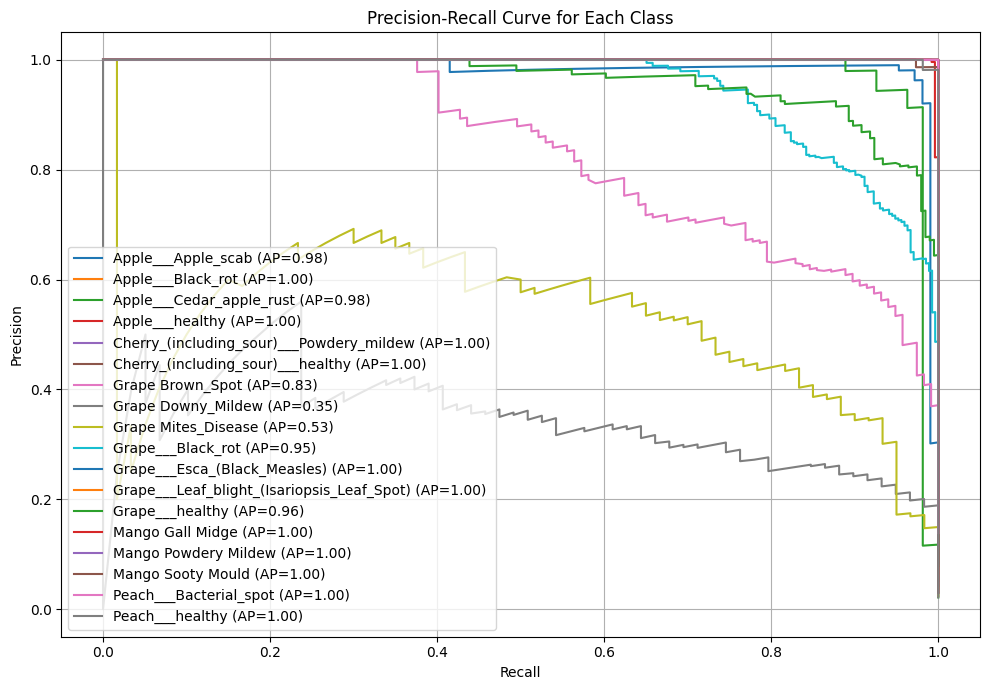

In [12]:
import torch.nn.functional as F

all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        probs = F.softmax(outputs, dim=1)  # ← đây là xác suất

        preds = outputs.argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())  # ← lưu xác suất
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import numpy as np

classes = np.arange(num_classes)  # hoặc: classes = list(range(num_classes))
y_true_bin = label_binarize(all_labels, classes=classes)
y_score = np.array(all_probs)

plt.figure(figsize=(10, 7))
for i in range(num_classes):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_score[:, i])
    ap = average_precision_score(y_true_bin[:, i], y_score[:, i])
    plt.plot(recall, precision, label=f"{class_names[i]} (AP={ap:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for Each Class")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [13]:
from sklearn.metrics import classification_report

print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))


                                            precision    recall  f1-score   support

                        Apple___Apple_scab     0.9630    0.9811    0.9720       106
                         Apple___Black_rot     1.0000    1.0000    1.0000        93
                  Apple___Cedar_apple_rust     0.9615    0.9259    0.9434        54
                           Apple___healthy     1.0000    0.9920    0.9960       251
  Cherry_(including_sour)___Powdery_mildew     1.0000    1.0000    1.0000       158
         Cherry_(including_sour)___healthy     1.0000    1.0000    1.0000       128
                          Grape Brown_Spot     0.7935    0.6239    0.6986       117
                        Grape Downy_Mildew     0.4615    0.2034    0.2824        59
                       Grape Mites_Disease     0.5625    0.6000    0.5806        60
                         Grape___Black_rot     0.7709    0.9154    0.8370       272
              Grape___Esca_(Black_Measles)     1.0000    1.0000    1.0000  

In [3]:
import os
import shutil
from pathlib import Path
from torchvision import datasets
from sklearn.model_selection import train_test_split
from collections import defaultdict
import pickle


# ==== Đường dẫn thư mục gốc và thư mục mới ====
data_dir = r"C:/Users/Admin/Documents/Python Project/Res conn 2025/final_data/not_seg"
new_test_dir = Path("test_data_extracted")  # nơi lưu ảnh test
new_test_dir.mkdir(parents=True, exist_ok=True)

# ==== Load full dataset ====
full_dataset = datasets.ImageFolder(data_dir)
class_names = full_dataset.classes
num_classes = len(class_names)

# ==== Chia dữ liệu train/val/test ====
train_idx, temp_idx = train_test_split(
    list(range(len(full_dataset.targets))),
    test_size=0.2,
    stratify=full_dataset.targets,
    random_state=42
)

val_idx, test_idx = train_test_split(
    temp_idx,
    test_size=0.5,
    stratify=[full_dataset.targets[i] for i in temp_idx],
    random_state=42
)

# ==== Copy ảnh trong test set ====
for idx in test_idx:
    # Lấy path gốc của ảnh
    image_path, label_idx = full_dataset.samples[idx]
    class_name = full_dataset.classes[label_idx]

    # Tạo thư mục class trong test_data_extracted nếu chưa có
    class_dir = new_test_dir / class_name
    class_dir.mkdir(parents=True, exist_ok=True)

    # Copy ảnh sang test_data_extracted/class_name/
    filename = os.path.basename(image_path)
    shutil.copy(image_path, class_dir / filename)

print("✅ Test images copied successfully.")


✅ Test images copied successfully.
